In [296]:
import string
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from xgboost import XGBClassifier

nltk.download('stopwords')
en_stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cameliaguerraoui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [297]:
_PATH = "8-9_Data"
_FILE_NAME = "spam_or_ham.csv"
_LABEL = "label"
_MSG = "messages"
_TOKEN = "token"
_LENGTH = "length"

# Spam Detector

https://blog.paperspace.com/nlp-spam-detection-application-with-scikitlearn-xgboost/

file:///Users/cameliaguerraoui/Downloads/Data_Pre_processing_in_Spam_Detection.pdf

In [298]:
df = pd.read_csv(f"{_PATH}/{_FILE_NAME}")
df.columns = [_LABEL, _MSG]
df.describe()

,label,messages
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [299]:
_STEMMER = PorterStemmer()

def text_preprocess(message: str, stemmer: object = _STEMMER) -> list:
    tokens = word_tokenize(message)
    final_list = []
    for token in tokens:
        out_punc = re.sub(r'\W+', "", token)
        if len(out_punc) > 2 and out_punc.lower() not in en_stop_words:
            stem = stemmer.stem(out_punc)
            final_list.append(stem)
    return final_list

In [300]:
spam_messages = df[df[_LABEL] == "spam"][_MSG]
ham_messages = df[df[_LABEL] == "ham"][_MSG]
print(f"Number of spam messages: {len(spam_messages)}")
print(f"Number of ham messages: {len(ham_messages)}")

Number of spam messages: 747
Number of ham messages: 4825


In [301]:
def _top_10_word_by_label(messages: list, label: str) -> None:
    words = []
    for message in messages:
        words += text_preprocess(message)
    print(f"Top 10 {label} words are:\n{pd.Series(words).value_counts().head(10)}")

_top_10_word_by_label(spam_messages, "spam")
print("---------------------------------")
_top_10_word_by_label(ham_messages, "ham")

Top 10 spam words are:
call     366
free     219
txt      169
text     139
mobil    135
stop     118
claim    115
repli    112
prize     94
get       88
dtype: int64
---------------------------------
Top 10 ham words are:
        1220
get      360
nt       351
come     298
call     294
know     249
love     247
like     246
got      245
good     232
dtype: int64


In [302]:
df[_TOKEN] = df[_MSG].apply(text_preprocess)
df[_TOKEN] = df[_TOKEN].agg(lambda x: " ".join(map(str, x)))
df.head()

,label,messages,token
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazi avail bugi great world buff...
1,ham,Ok lar... Joking wif u oni...,lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win cup final tkt 21st ma...
3,ham,U dun say so early hor... U c already then say...,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah nt think goe usf live around though


In [303]:
# Bag of Words Method
vectorizer = CountVectorizer()
bow_transformer = vectorizer.fit(df[_TOKEN])

# Fetch the vocabulary set
print(f"20 BOW Features: {vectorizer.get_feature_names()[20:40]}")
print(f"Total number of vocab words: {len(vectorizer.vocabulary_)}")

20 BOW Features: ['07090201529', '07090298926', '07099833605', '071104', '07123456789', '0721072', '07732584351', '07734396839', '07742676969', '07753741225', '0776xxxxxxx', '07786200117', '077xxx', '078', '07801543489', '07808', '07808247860', '07808726822', '07815296484', '07821230901']
Total number of vocab words: 7545


In [304]:
# Convert strings to vectors using BoW
messages_bow = bow_transformer.transform(df[_TOKEN])
print(f"Shape of sparse matrix: {messages_bow.shape}")
print(f"Amount of non-zero occurrences: {messages_bow.nnz}")

Shape of sparse matrix: (5572, 7545)
Amount of non-zero occurrences: 43759


In [305]:
# Transform entire BoW into tf-idf corpus
tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 7545)


In [306]:
# Convert ham and spam labels to 0 and 1
FactorResult = pd.factorize(df[_LABEL])
df[_LABEL] = FactorResult[0]
df.head()

,label,messages,token
0,0,"Go until jurong point, crazy.. Available only ...",jurong point crazi avail bugi great world buff...
1,0,Ok lar... Joking wif u oni...,lar joke wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win cup final tkt 21st ma...
3,0,U dun say so early hor... U c already then say...,dun say earli hor alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah nt think goe usf live around though


In [307]:
def _print_shape(X: object, y: object, set: str) -> None:
    print(f"{set} dataset features size: {X.shape}")
    print(f"{set} dataset label size: {y.shape}\n")

X_train, X_test, y_train, y_test = train_test_split(
    messages_tfidf, df[_LABEL], test_size=0.3, stratify=df[_LABEL].tolist()
)

_print_shape(X_train, y_train, "Train")
_print_shape(X_test, y_test, "Test")

Train dataset features size: (3900, 7545)
Train dataset label size: (3900,)

Test dataset features size: (1672, 7545)
Test dataset label size: (1672,)



In [308]:
clf = XGBClassifier()
clf.fit(X_train, y_train)
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

In [309]:
from sklearn.metrics import classification_report

def _get_accuracy(predict: object, y: object, dataset: str):
    print(f"Accuracy for the {dataset} dataset: {accuracy_score(y, predict)*100:.3}%")
    print(f"Confusion Matrix:\n{confusion_matrix(predict, y)}")
    print(classification_report(y, predict))
    print()

#_get_accuracy(predict_train, y_train, "train")
_get_accuracy(predict_test, y_test, "test")

Accuracy for the test dataset: 97.8%
Confusion Matrix:
[[1438   27]
 [  10  197]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1448
           1       0.95      0.88      0.91       224

    accuracy                           0.98      1672
   macro avg       0.97      0.94      0.95      1672
weighted avg       0.98      0.98      0.98      1672




In [310]:
import sklearn
k_folds = sklearn.model_selection.KFold(n_splits = 5)
values = sklearn.model_selection.cross_val_score(clf, X_train, y_train, cv = k_folds, scoring="accuracy")
print("Eval Train: ", values.mean())
values = sklearn.model_selection.cross_val_score(clf, X_test, y_test, cv = k_folds, scoring="accuracy")
print("Eval Test : ", values.mean())

Eval Train:  0.9682051282051282
Eval Test :  0.958730896416123


# Autre

In [311]:
def _filter_punctuaction(tokens: str) -> None:
    tokens_list = []
    for token in tokens:
        token_out_punctuation = re.sub(r'\W+', "", token)
        if len(token_out_punctuation) > 1:
            tokens_list.append(token_out_punctuation)
    return tokens_list

def _get_tokens(message: str) -> list:
    all_tokens = word_tokenize(message)
    filtered_tokens = [word for word in all_tokens if not word.lower() in en_stop_words]
    tokens_list = _filter_punctuaction(filtered_tokens)
    return tokens_list

df[_TOKEN] = df[_MSG].apply(_get_tokens)

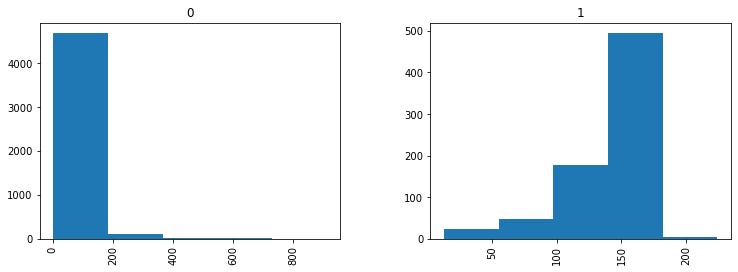

In [312]:
df[_LENGTH] = df[_MSG].apply(len)
df.sort_values(by=_LENGTH, ascending=False).head(10)
df.hist(column=_LENGTH, by=_LABEL,figsize=(12,4), bins = 5)
plt.show()

In [313]:
# one way to fix it is to downsample the ham msg
ham_msg_df = df[df[_LABEL] == "ham"].sample(n=len(spam_messages), random_state = 44)
spam_msg_df = df[df[_LABEL] == "spam"]
print(ham_msg_df.shape, spam_msg_df.shape)
df = pd.DataFrame(ham_msg_df.append(spam_msg_df).reset_index(drop=True))
df.columns = [_LABEL, _MSG]
print(len(df))


ValueError: a must be greater than 0 unless no samples are taken

In [ ]:
'''
# Remove punctuations
no_punc = [char for char in message if char not in string.punctuation]

# Join the characters again
no_punc = "".join(no_punc)
no_punc = no_punc.lower()

# Remove any stopwords and non-alphabetic characters
no_stop_word = [
    word
    for word in no_punc.split()
    if word.lower() not in en_stop_words and word.isalpha()
]
'''